In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import time
import matplotlib.pyplot as plt

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [3]:
# Merge datasets
order_products = pd.concat([order_products_prior, order_products_train], ignore_index=True)
merged_data = orders.merge(order_products, on='order_id', how='inner')
merged_data = merged_data.merge(products, on='product_id', how='inner')
merged_data = merged_data.merge(aisles, on='aisle_id', how='inner')
merged_data = merged_data.merge(departments, on='department_id', how='inner')

In [4]:
# Define features and target
X = merged_data.drop(columns=['reordered'])  
y = merged_data['reordered']

In [5]:
# Handle non-numeric columns: drop non-numeric columns for now
non_numeric_cols = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_cols)  # Drop non-numeric columns

In [6]:
# Identify and handle non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index([], dtype='object')


In [7]:
# Sample the data for faster experimentation (use only 10% of the dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.sample(frac=0.1, random_state=42)  # Use only 10% of the training data
y_train = y_train.loc[X_train.index]  # Match the target to the sample

In [8]:
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)  # Fit and transform on the training set
X_test_imputed = imputer.transform(X_test)

In [9]:
model_results = {}
rf_param_grid = {
    'n_estimators': [100],  # Use fewer estimators for faster runs
    'max_depth': [10],  # Limit the max depth for faster computation
    'min_samples_split': [2],
    'bootstrap': [True]
}

xgb_param_grid = {
    'n_estimators': [50],  # Use fewer estimators for faster runs
    'max_depth': [3],  # Use smaller trees
    'learning_rate': [0.1],  # Default learning rate
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# RANDOMFOREST VS XGBOOST

In [11]:
# Set up RandomizedSearchCV for Random Forest
print("Tuning Random Forest model...")
start_time = time.time()
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
                                      param_distributions=rf_param_grid, n_iter=5, cv=2, n_jobs=-1, verbose=1, scoring='accuracy')
rf_random_search.fit(X_train_imputed, y_train)

print(f"Best parameters for Random Forest: {rf_random_search.best_params_}")
rf_best = rf_random_search.best_estimator_
print(f"Random Forest training time: {time.time() - start_time:.2f} seconds")

# Set up RandomizedSearchCV for XGBoost
print("Tuning XGBoost model...")
start_time = time.time()
xgb_random_search = RandomizedSearchCV(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
                                      param_distributions=xgb_param_grid, n_iter=5, cv=2, n_jobs=-1, verbose=1, scoring='accuracy')
xgb_random_search.fit(X_train_imputed, y_train)

print(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")
xgb_best = xgb_random_search.best_estimator_
print(f"XGBoost training time: {time.time() - start_time:.2f} seconds")

# Train the tuned Random Forest model
print("Training Random Forest model with best parameters...")
y_pred_rf = rf_best.predict(X_test_imputed)
model_results = {
    'Random Forest': {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'mse': mean_squared_error(y_test, y_pred_rf),
        'r2': r2_score(y_test, y_pred_rf)
    }
}

# Train the tuned XGBoost model
print("Training XGBoost model with best parameters...")
y_pred_xgb = xgb_best.predict(X_test_imputed)
model_results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'mse': mean_squared_error(y_test, y_pred_xgb),
    'r2': r2_score(y_test, y_pred_xgb)
}

Tuning Random Forest model...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\anura\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10, 'bootstrap': True}
Random Forest training time: 261.49 seconds
Tuning XGBoost model...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\anura\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\anura\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [07:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost training time: 22.50 seconds
Training Random Forest model with best parameters...
Training XGBoost model with best parameters...



Model Performance:

Random Forest Results:
Accuracy: 0.7251
MSE: 0.2749
R²: -0.1363

XGBoost Results:
Accuracy: 0.7210
MSE: 0.2790
R²: -0.1533


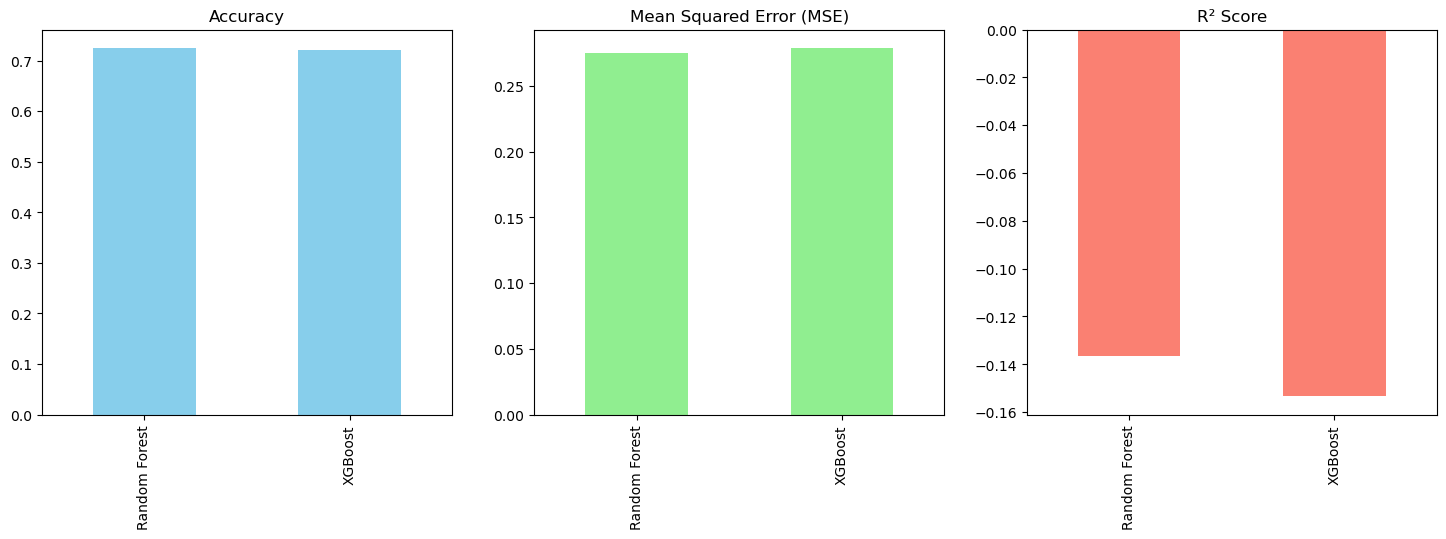

In [12]:
print("\nModel Performance:")
for model_name, metrics in model_results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")

### Plotting Results ###

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(model_results).T

# Plot Accuracy, MSE, R² for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df['accuracy'].plot(kind='bar', ax=axes[0], color='skyblue', title="Accuracy")
results_df['mse'].plot(kind='bar', ax=axes[1], color='lightgreen', title="Mean Squared Error (MSE)")
results_df['r2'].plot(kind='bar', ax=axes[2], color='salmon', title="R² Score")
plt.show()